In [1]:
%config InlineBackend.figure_format='retina'

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, gridspec

In [2]:
# Corresponds to Equation (8)
# variable `x` here corresponds to \gamma in Eq. (8)
# variable `lm` here corresponds to \lambda in Eq. (8)
# here we accelerate computation by precomputing np.power(x, a) and np.power(x, b)
def model_accel(x, xa, xb, param):
    h, p, a, b, c, k, lm = param
    g0 = h*p
    s0 = h*(1-p)
    hg = (1-x)*g0
    hs = s0*((1-xa)+c*(x-xa))
    cost = k*xb
    herbivory = hs+hg+lm*h*p*(1-p)*(1-x)*((1-xa)+c*(x-xa))
    fitness = -cost-herbivory
    return fitness

# See Fig. 1
def optimal_surface(param, shape):
    a, b, c, k, lm = param
    xsize, hsize, psize = shape
    
    mat = np.zeros(shape=(hsize, psize))
    
    xrng = np.linspace(0, 1, xsize)
    hrng = np.linspace(0, 2, hsize)
    prng = np.linspace(0, 1, psize)
    
    xa = np.power(xrng, a)
    xb = np.power(xrng, b)
    
    for hind, h in enumerate(hrng):
        for pind, p in enumerate(prng):
            f = model_accel(xrng, xa, xb, [h,p,a,b,c,k,lm])
            ind_max = np.argmax(f)
            val_max = xrng[ind_max]
            mat[hind, pind] = val_max
    
    return mat, hrng, prng

# mb refers to marginal benefit
# mc refers to marginal cost
# g: generalist
# s: specialist
def mb_g(x, h, p):
    return h*p*np.ones_like(x)

def mb_s(x, h, p, a, c):
    return h*(1-p)*(a*(c+1)*np.power(x,a-1)-c)

def mb(x, h, p, a, c):
    return h*p*np.ones_like(x)+h*(1-p)*(a*(c+1)*np.power(x,a-1)-c)

def mc(x, k, b):
    return np.power(x, b)*k

In [12]:
# drawing f(p)
def plot_fp(mat, prng, hrng, ax):
    one_mat = np.ones_like(mat)
    dp_mat = np.zeros_like(mat)
    dp_mat[:,:-1] = np.diff(mat, axis=1)
    dp_mat[:,-1] = dp_mat[:,-2]
    area_1 = (one_mat*(mat==1)).astype('bool')
    area_2 = (one_mat*(dp_mat<0)).astype('bool')&(one_mat*(mat!=1)).astype('bool')
    area_3 = one_mat.astype('bool')^(area_1|area_2)
    h, p = area_2.shape
    l = []
    u = []
    for j in range(p):
        ll = []
        for i in range(h):
            if area_2[i,j] > 0.5:
                ll.append(i)
        min_val = np.min(ll)
        max_val = np.max(ll)
        l.append(min_val)
        u.append(max_val)

    ax.plot(prng, hrng[u], '--', color='black', linewidth=1)
    ax.plot(prng, hrng[l], color='black', linewidth=1)
    
def calc_fp(mat, hrng):
    one_mat = np.ones_like(mat)
    dp_mat = np.zeros_like(mat)
    dp_mat[:,:-1] = np.diff(mat, axis=1)
    dp_mat[:,-1] = dp_mat[:,-2]
    area_1 = (one_mat*(mat==1)).astype('bool')
    area_2 = (one_mat*(dp_mat<0)).astype('bool')&(one_mat*(mat!=1)).astype('bool')
    area_3 = one_mat.astype('bool')^(area_1|area_2)
    h, p = area_2.shape
    l = []
    u = []
    for j in range(p):
        ll = []
        for i in range(h):
            if area_2[i,j] > 0.5:
                ll.append(i)
        min_val = np.min(ll)
        max_val = np.max(ll)
        l.append(min_val)
        u.append(max_val)
    return hrng[l]

In [ ]:
# Fig. 1
def plot_ng(fig, ax1, ax2, lm, pts, xon):
    # setup model parameters
    a = 1.7
    b = 1.9
    c = 0.0
    k = 1.0
    #lm = -0.5

    # setup simulation parameters
    # to obtain a high resolution figure, we set a smaller interval here 
    xsize = 100000
    hsize = 400
    psize = 100

    param = [a, b, c, k, lm]
    shape = [xsize, hsize, psize]

    # run model
    mat, hrng, prng = optimal_surface(param, shape)

    # BEGIN ax1 ploting
    X, Y = np.meshgrid(prng, hrng)
    cf = ax1.contourf(X, Y, mat, 10, cmap=cm.coolwarm)
    fig.colorbar(cf, ax=ax1, spacing='uniform', boundaries=[0,1])
    plot_fp(mat, prng, hrng, ax1)
    if xon:
        ax1.set_xlabel('$p$', fontsize=18)
    ax1.set_ylabel('$H_0$', fontsize=18)
    # END ax1 ploting

    # BEGIN ax2 ploting
    n = 10
    label = []
    for hind, h in list(enumerate(hrng))[::hsize//n]:
        slice_hx = mat[hind,:]
        label.append(h)
        ax2.plot(prng, slice_hx, color='black', linewidth=1)
    label.reverse()
    #pts = [[0.9552466793168881, 0.9614285714285715], [0.8545509171410499, 0.8857142857142857], [0.6589025932953829, 0.7688311688311689], [0.37057874762808396, 0.6025974025974026], [0.22641682479443448, 0.35324675324675325], [0.3680044275774832, 0.2], [0.5610784313725494, 0.16103896103896104], [0.7387065148640102, 0.12467532467532466], [0.9137602783048706, 0.07012987012987013]]
    for ind, (x, y) in enumerate(pts):
        ax2.text(
            x = x, 
            y = y, 
            s = '%.1f'%label[ind], 
            bbox={'facecolor':'white', 'edgecolor':'None', 'alpha':1, 'pad':1},
            horizontalalignment='center',
            verticalalignment='center'
        )
    if xon:
        ax2.set_xlabel('$p$', fontsize=18)
    ax2.set_ylabel('$\gamma*$', fontsize=18)
    ax2.set_xlim([0,1])
    ax2.set_ylim([0,1])
    # END ax2 ploting

plt.rcParams['font.size'] = 12
fig, ((ax1, ax2), 
      (ax3, ax4), 
      (ax5, ax6)) = plt.subplots(3, 2, gridspec_kw={'width_ratios':[1, 0.85]}, figsize=(12,15))
pts = [[0.9552466793168881, 0.9614285714285715], [0.8545509171410499, 0.8857142857142857], [0.6589025932953829, 0.7688311688311689], [0.37057874762808396, 0.6025974025974026], [0.22641682479443448, 0.35324675324675325], [0.3680044275774832, 0.2], [0.5610784313725494, 0.16103896103896104], [0.7387065148640102, 0.12467532467532466], [0.9137602783048706, 0.07012987012987013]]
plot_ng(fig, ax1, ax2, -0.5, pts, 0)
pts = [[0.9550980392156861, 0.9618311688311688], [0.8571252371916511, 0.8987012987012988], [0.7103889943074004, 0.8233766233766233], [0.4658285895003167, 0.7376623376623377], [0.298497786211259, 0.5172727272727273], [0.4632542694497159, 0.34285714285714286], [0.6074161922833654, 0.2337662337662338], [0.7670240354206199, 0.15584415584415584], [0.9192061986084756, 0.07092207792207792]]
plot_ng(fig, ax3, ax4, 0.0, pts, 0)
pts = [[0.9553851992409868, 0.9612337662337663], [0.8841555977229603, 0.903896103896104], [0.7631625553447186, 0.8467532467532468], [0.5855344718532578, 0.7740259740259741], [0.3306767868437701, 0.6441558441558441], [0.40533206831119584, 0.43896103896103894], [0.48256166982922233, 0.2805194805194805], [0.6627640733712843, 0.17402597402597403], [0.81494623655914, 0.07092207792207792]]
plot_ng(fig, ax5, ax6, 0.5, pts, 1)
plt.show()

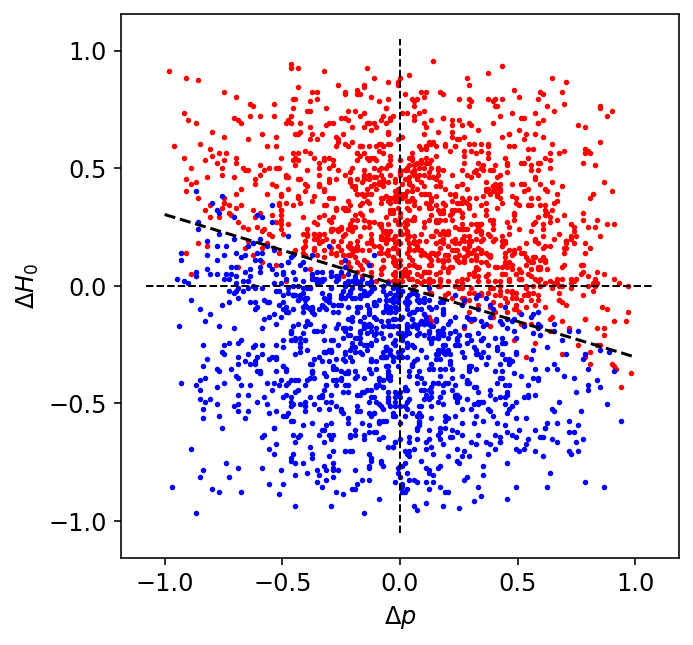

0.966495861253449 -0.30303030303030276


In [17]:
# Fig.2

a = 1.7
b = 1.9
c = 0.0
k = 1.0
lm = 0

xsize = 1000
hsize = 200
psize = 100

param = [a, b, c, k, lm]
shape = [xsize, hsize, psize]

mat, hrng, prng = optimal_surface(param, shape)

def montecarlo(mat, hrng, prng, nsim):
    fp = calc_fp(mat, hrng)
    
    np.diff(mat)
    
    hsize, psize = len(hrng), len(prng)
    hsample = np.random.randint(0, hsize, size=(nsim, 2))
    psample = np.random.randint(0, psize, size=(nsim, 2))
    
    increase = []
    decrease = []
    unchange = []
    
    for (h1, h2), (p1, p2) in zip(hsample, psample):
        d1 = mat[h1, p1]
        d2 = mat[h2, p2]
        dd = d2 - d1
        dh = hrng[h2] - hrng[h1]
        dp = prng[p2] - prng[p1]
        
        cond_c = (hrng[h1] >= fp[p1] and hrng[h2] < fp[p2]) or (hrng[h1] < fp[p1] and hrng[h2] >= fp[p2])
        cond_a = hrng[h1] > fp[p1] and hrng[h2] > fp[p2]
        cond_b = hrng[h1] <= fp[p1] and hrng[h2] <= fp[p2]
        
        if cond_b:
            if dd > 0:
                increase.append([dp, dh])
            elif dd < 0:
                decrease.append([dp, dh])
    
    return increase, decrease

plt.figure(figsize=(5,5))
increase, decrease = montecarlo(mat, hrng, prng, 10000)
x, y = zip(*increase)
plt.scatter(x, y, s=3, c='red')
xm, ym = max(x), max(y)

x, y = zip(*decrease)
plt.scatter(x, y, s=3, c='blue')
xm, ym = max(max(x), xm), max(max(y), ym)

plt.plot([-(xm+0.1*xm), xm+0.1*xm], [0, 0], '--', color='black', linewidth=1)
plt.plot([0, 0], [-(ym+0.1*ym), ym+0.1*ym], '--', color='black', linewidth=1)
plt.xlabel('$\Delta p$')
plt.ylabel('$\Delta H_0$')

dp, dh = zip(*(increase+decrease))
dp = np.array(dp)
dh = np.array(dh)

tag = [1 for i in increase] + [0 for i in decrease]

ev = []
for k in np.linspace(-10, 10, 100):
    r = (dp*k - dh < 0) == tag
    ev.append(np.sum(r) / len(r))
ind = np.argmax(ev)

k = np.linspace(-10, 10, 100)[ind]
xx = np.linspace(-1,1,100)
plt.plot(xx, xx*k, '--',color='black')

plt.show()
print(ev[ind], k)

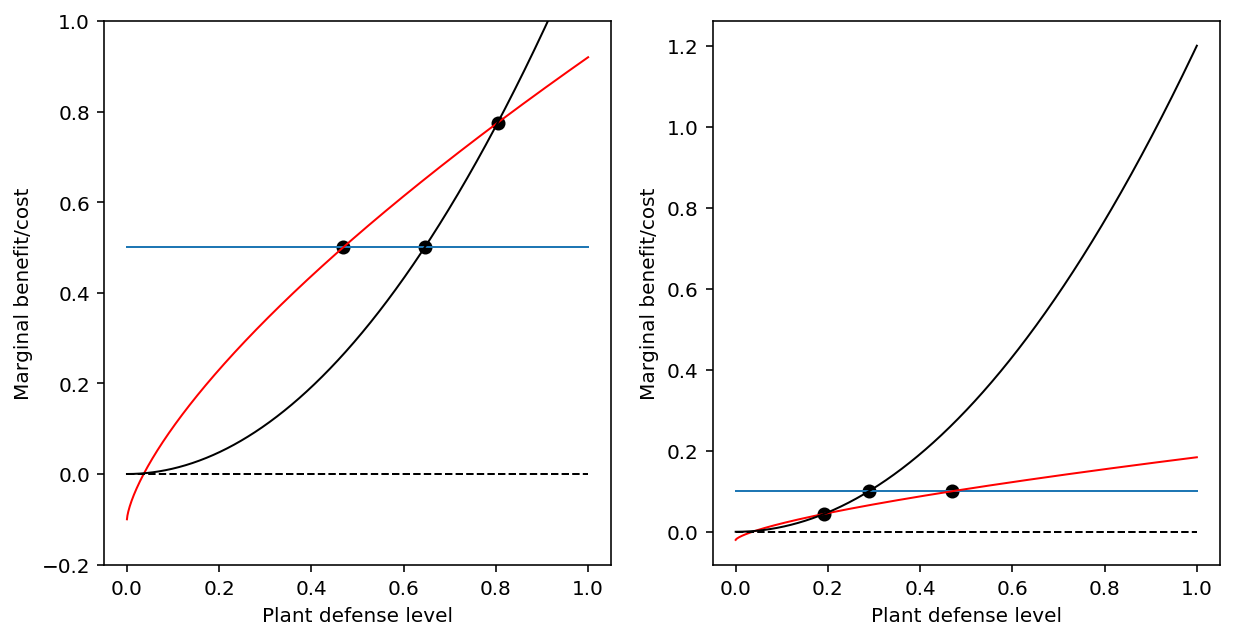

In [8]:
# Fig. 3

x = np.linspace(0, 1, 1000)
a = 1.7
c = 0.2

plt.figure(figsize=(10,5))

plt.subplot(121)
plt.ylim([-0.2, 1])

h0 = 0.5
plt.plot(x, mb(x, h0, 1, 1.7, c), linewidth=1)
plt.plot(x, mb(x, h0, 0, 1.7, c), linewidth=1, color='r')

plt.plot(x, mc(x, 1.2, 2), color='black', linewidth=1)

xx = np.argmin(abs(mb(x, h0, 1, a, c) - mb(x, h0, 0, a, c)))
plt.scatter([x[xx]],[h0], color='black')
xx = np.argmin(abs(mb(x, h0, 1, a, c) - mc(x, 1.2, 2)))
plt.scatter([x[xx]],[h0], color='black')
ss = 1
xx = np.argmin(abs(mb(x, h0, 0, a, c) - mc(x, 1.2, 2))[ss:])
plt.scatter([x[ss+xx]],[mb(x, h0, 0, a, c)[ss+xx]], color='black')

plt.plot([0,1],[0,0], '--', color='black', linewidth=1)

plt.xlabel('Plant defense level')
plt.ylabel('Marginal benefit/cost')

plt.subplot(122)
h0 = 0.1
plt.plot(x, mb(x, h0, 1, 1.7, c), linewidth=1)
plt.plot(x, mb(x, h0, 0, 1.7, c), linewidth=1, color='red')

plt.plot(x, mc(x, 1.2, 2), color='black', linewidth=1)

xx = np.argmin(abs(mb(x, h0, 1, a, c) - mb(x, h0, 0, a, c)))
plt.scatter([x[xx]],[h0], color='black')
xx = np.argmin(abs(mb(x, h0, 1, a, c) - mc(x, 1.2, 2)))
plt.scatter([x[xx]],[h0], color='black')
ss = 1
xx = np.argmin(abs(mb(x, h0, 0, a, c) - mc(x, 1.2, 2))[ss:])
plt.scatter([x[ss+xx]],[mb(x, h0, 0, a, c)[ss+xx]], color='black')

plt.plot([0,1],[0,0], '--', color='black', linewidth=1)

plt.xlabel('Plant defense level')
plt.ylabel('Marginal benefit/cost')

plt.show()

In [19]:
import matplotlib.pyplot as plt
import mpl_toolkits.axisartist as axisartist


def setup_axes(fig, rect, pos=(0,0)):
    x, y = pos
    ax = axisartist.Subplot(fig, rect)
    fig.add_axes(ax)

    ax.set_ylim(-0.1, 1.1)
    ax.set_yticks([])
    ax.set_xlim(-0.1, 1.1)
    ax.set_xticks([])

    ax.axis[:].set_visible(False)

    ax.axis["x"] = ax.new_floating_axis(0, x)
    ax.axis["x"].set_axisline_style("->", size=1.5)
    
    ax.axis["y"] = ax.new_floating_axis(1, y)
    ax.axis["y"].set_axisline_style("->", size=1.5)

    return ax

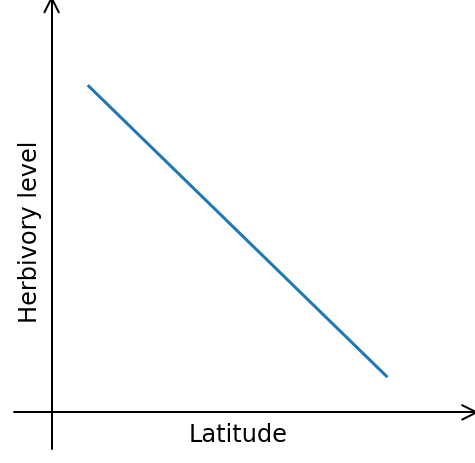

In [152]:
fig = plt.figure(figsize=(4, 4))

ax = setup_axes(fig, "111")
ax.axis["x"].label.set_text("Latitude")
ax.axis["x"].toggle(ticklabels=False)

ax.axis["y"].label.set_text("Herbivory level")
ax.axis["y"].set_axis_direction("top")
ax.axis["y"].toggle(ticklabels=False)

x = np.linspace(0.1, 0.9, 10)
y = -x+1
ax.plot(x, y)
plt.show()

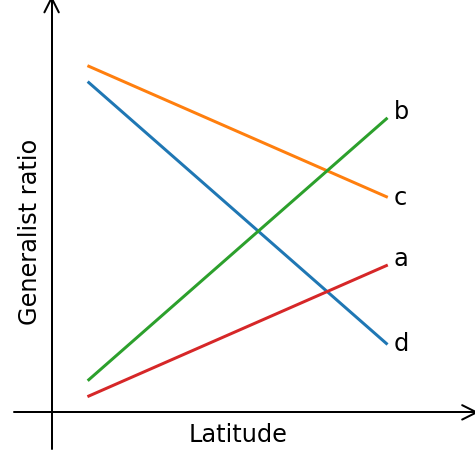

In [293]:
fig = plt.figure(figsize=(4, 4))
ax = setup_axes(fig, "111")
ax.axis["x"].label.set_text("Latitude")
ax.axis["x"].toggle(ticklabels=False)

ax.axis["y"].label.set_text("Generalist ratio")
ax.axis["y"].set_axis_direction("top")
ax.axis["y"].toggle(ticklabels=False)

x = np.linspace(0.1, 0.9, 10)

lc = ax.plot(x, -0.9*x + 1)
ld = ax.plot(x, -0.45*x + 1)
la = ax.plot(x, 0.9*x)
lb = ax.plot(x, 0.45*x)

ax.text(x[-1]+0.02, (-0.9*x+1)[-1]-0.02, 'd')
ax.text(x[-1]+0.02, (-0.45*x+1)[-1]-0.02, 'c')
ax.text(x[-1]+0.02, (0.9*x)[-1], 'b')
ax.text(x[-1]+0.02, (0.45*x)[-1], 'a')

plt.show()

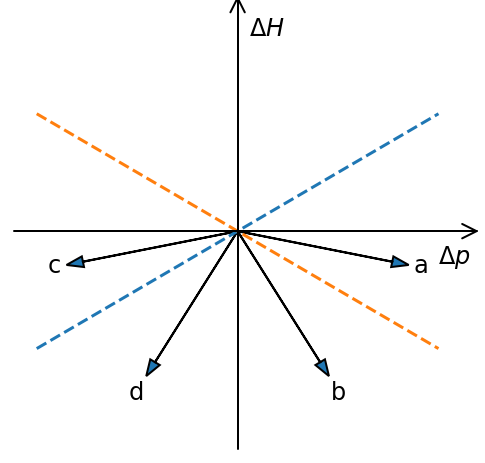

In [286]:

fig = plt.figure(figsize=(4, 4))


ax = setup_axes(fig, "111")
ax.axis["x"].toggle(ticklabels=False)
ax.axis["y"].toggle(ticklabels=False)

x = np.linspace(-0.9, 0.9, 10)
ax.plot(x, 0.6*x, '--')
ax.plot(x, -0.6*x, '--')
#ax.plot(x, 0*x, linewidth=2.5, color='black')
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
dx = 0.37

ax.arrow(0, 0, 0.693, -np.sqrt(0.5-0.693**2), head_width=0.05)
ax.arrow(0, 0, 0.37, -np.sqrt(0.5-0.37**2), head_width=0.05)
ax.arrow(0, 0, -0.693, -np.sqrt(0.5-0.693**2), head_width=0.05)
ax.arrow(0, 0, -0.37, -np.sqrt(0.5-0.37**2), head_width=0.05)

ax.text(0.79, -np.sqrt(0.5-0.693**2)-0.05, 'a')
ax.text(0.42, -np.sqrt(0.5-0.37**2)-0.17, 'b')

ax.text(-0.85, -np.sqrt(0.5-0.693**2)-0.05, 'c')
ax.text(-0.49, -np.sqrt(0.5-0.37**2)-0.17, 'd')

ax.text(0.05, 0.9, '$\Delta H$')
ax.text(0.9, -0.15, '$\Delta p$')
plt.show()

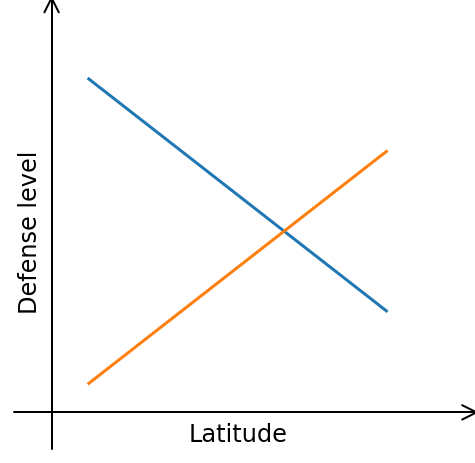

In [20]:
fig = plt.figure(figsize=(4, 4))
ax = setup_axes(fig, "111")
ax.axis["x"].label.set_text("Latitude")
ax.axis["x"].toggle(ticklabels=False)

ax.axis["y"].label.set_text("Defense level")
ax.axis["y"].set_axis_direction("top")
ax.axis["y"].toggle(ticklabels=False)

x = np.linspace(0.1, 0.9, 10)

ax.plot(x, -0.8*x + 1)
ax.plot(x, 0.8*x)
plt.show()

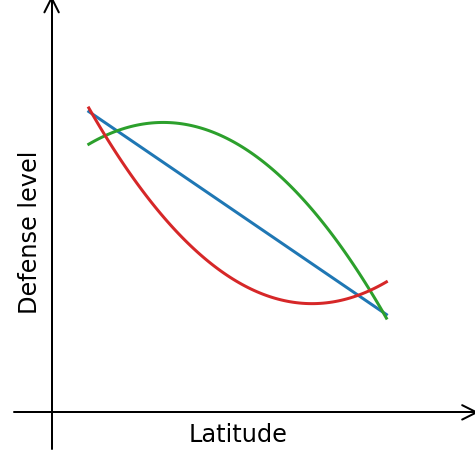

In [368]:
fig = plt.figure(figsize=(4, 4))
ax = setup_axes(fig, "111")
ax.axis["x"].label.set_text("Latitude")
ax.axis["x"].toggle(ticklabels=False)

ax.axis["y"].label.set_text("Defense level")
ax.axis["y"].set_axis_direction("top")
ax.axis["y"].toggle(ticklabels=False)

x = np.linspace(0.1, 0.9, 100)

ax.plot(x, -0.7*x+0.9)
ax.plot([99],[99])
ax.plot(x, -1.5*(x-0.3)**2 + 0.8)

ax.plot(x, 1.5*(x-0.7)**2 + 0.3)

plt.show()